In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
%matplotlib inline

In [ ]:
train = pd.read_csv("../data/train.csv")
test  = pd.read_csv("../data/test.csv")

In [13]:
# train = pd.read_csv('s3a://aws-s3-data/kaggle/titanic/train.csv')
# test  = pd.read_csv('s3a://aws-s3-data/kaggle/titanic/test.csv')

## Exploratory Data Analysis

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


In [15]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# train.Cabin.str.split().str.get(-1).str[0]
# train.Cabin.str.split(expand=True)

In [16]:
# train.Ticket.str.split().str.get(0).str.extract
train.Ticket.str.split()[0:].str[0].head()

0         A/5
1          PC
2    STON/O2.
3      113803
4      373450
dtype: object

In [20]:
print train[train['Survived']==1]["Age"].mean(),
print train[train['Survived']==0]["Age"].mean(),
print test.Age.mean()

28.3436896552 30.6261792453 30.2725903614


## Data Cleaning

In [21]:
def clean_data(titanic):

    titanic = titanic.copy()
    
    titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
    titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())
    titanic['Cabin'] = titanic['Cabin'].str.split().str.get(-1).str[0]
    titanic['Ticket'] = titanic.Ticket.str.split()[0:].str[0]
    
    titanic.loc[titanic["Sex"] == "male", "Sex"] = -10
    titanic.loc[titanic["Sex"] == "female", "Sex"] = 10
    
    titanic["Embarked"] = titanic["Embarked"].fillna("S")
    
    titanic['Title'] = titanic['Name'].apply(lambda x: x.split(',')[1].split()[0])

#     d = {'Mr.':'Mr', 'Mrs.':'Mrs', 'Miss.':'Miss', 'Master.':'Master', 'Don.':'Mr', 'Rev.':'Mr', 'Dr.':'Dr', 'Mme.':'Mrs',
#        'Ms.':'Miss', 'Major.':'Mr', 'Lady.':'Miss', 'Sir.':'Mr', 'Mlle.':'Miss', 'Col.':'Mr', 'Capt.':'Mr', 'the':'Mr',
#        'Jonkheer.':'Mr', 'Dona.':'Mrs'}
    
    d = {'Mr.':28, 'Mrs.':80, 'Miss.':50, 'Master.':28, 'Don.':40, 'Rev.':60, 'Dr.':60, 'Mme.':80,
       'Ms.':50, 'Major.':60, 'Lady.':70, 'Sir.':40, 'Mlle.':50, 'Col.':60, 'Capt.':60, 'the':28,
       'Jonkheer.':28, 'Dona.':70}

    titanic['Title'].replace(d, inplace =True)
    
    colnames = ['Embarked','Cabin','Ticket']
    for colname in colnames:
        titanic[colname] = pd.Categorical(titanic[colname]).codes

#     # Grab all the features that can be included in a Random Forest Regressor
#     age_titanic = titanic[['Age','Fare','Ticket','Pclass','Cabin','Title']]

#     # Split into sets with known and unknown Age values
#     knownAge = age_titanic.loc[ (titanic.Age.notnull()) ]
#     unknownAge = age_titanic.loc[ (titanic.Age.isnull()) ]
    
#     # All age values are stored in a target array
#     y = knownAge.pop('Age').values
  
#     # All the other values are stored in the feature array
#     X = knownAge.values
    
#     # Create and fit a model
#     rtr = RandomForestRegressor(20)
#     rtr.fit(X, y)
    
#     # Use the fitted model to predict the missing values
#     predictedAges = rtr.predict(unknownAge.values[:, 1::])
    
#     # Assign those predictions to the full data set
#     titanic.loc[ (titanic.Age.isnull()), 'Age' ] = predictedAges 
    
    
    # StandardScaler will subtract the mean from each value then scale to the unit variance
#     scaler = StandardScaler()
#     titanic['Age_scaled'] = scaler.fit_transform(titanic['Age'])
#     titanic['Fare_scaled'] = scaler.fit_transform(titanic['Fare'])
    
    titanic.Age = titanic.Age/titanic.Age.max()
    titanic.Fare = titanic.Fare/titanic.Fare.max()

    titanic['AgeSex'] = titanic.Age * titanic.Sex
    titanic['AgeSexFare'] = titanic.Age * titanic.Sex * titanic.Fare
#     titanic['TitlePclass'] = titanic.Title * titanic.Pclass
#     titanic['CabinPclass'] = titanic.Cabin * titanic.Pclass
#     titanic['PclassSq'] = titanic.Pclass ** 2
#     titanic['SexFare'] = titanic.Sex * titanic.Fare
#     titanic["FamilySize"] = titanic['Parch'] + titanic['SibSp']


#     titanic.loc[(titanic["Sex"] == "female") , "Age"] = \
#         titanic.loc[(titanic["Sex"] == "female") , "Age"].fillna(28.34)
#     titanic.loc[(titanic["Sex"] == "male") , "Age"] = \
#         titanic.loc[(titanic["Sex"] == "male") , "Age"].fillna(30.62)
#         (titanic[titanic['Survived']==0]["Age"].mean())    
    
#     titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 1
#     titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 2
#     titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 3
    
    titanic.drop(titanic[['Name', 
#                           'Ticket', 
#                           'Cabin',
#                           'Age',
#                           'Sex',
#                           'Fare',
                          'SibSp',
                          'Parch',
#                           'Title',
#                           'Pclass',
                         ]], axis = 1, inplace=True)
    
    return titanic

In [24]:
df = clean_data(train)
df_train = df.copy()
df_train.drop('PassengerId', axis=1, inplace=True)
df_test  = clean_data(test)

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891,446.000000,257.353842,1.00000,223.50000,446.000000,668.500000,891
Survived,891,0.383838,0.486592,0.00000,0.00000,0.000000,1.000000,1
Pclass,891,2.308642,0.836071,1.00000,2.00000,3.000000,3.000000,3
Age,891,0.367020,0.162746,0.00525,0.27500,0.350000,0.437500,1
Ticket,891,322.291807,179.517825,0.00000,158.50000,337.000000,516.500000,556
Fare,891,0.062858,0.096995,0.00000,0.01544,0.028213,0.060508,1
Cabin,891,-0.221100,1.599664,-1.00000,-1.00000,-1.000000,-1.000000,7
Embarked,891,1.536476,0.791503,0.00000,1.00000,2.000000,2.000000,2
Title,891,40.641975,18.612814,28.00000,28.00000,28.000000,50.000000,80


In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null object
Age           891 non-null float64
Ticket        891 non-null int16
Fare          891 non-null float64
Cabin         891 non-null int8
Embarked      891 non-null int8
Title         891 non-null int64
AgeSex        891 non-null object
AgeSexFare    891 non-null object
dtypes: float64(2), int16(1), int64(3), int8(2), object(3)
memory usage: 66.1+ KB


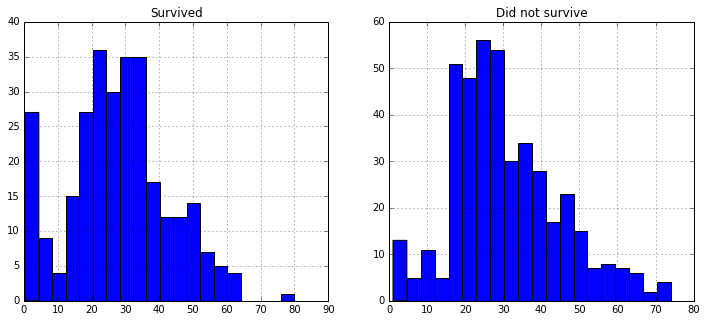

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
train[train['Survived']==1]["Age"].hist(bins=20, label='survived')
plt.title('Survived')
plt.subplot(1,2,2)
train[train['Survived']==0]["Age"].hist(bins=20)
plt.title('Did not survive')

In [29]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,AgeSex,AgeSexFare
0,1,0,3,-10,0.2750,518,0.014151,-1,2,28,-2.75,-0.0389154
1,2,1,1,10,0.4750,532,0.139136,2,0,80,4.75,0.660895
2,3,1,3,10,0.3250,551,0.015469,-1,2,50,3.25,0.0502729
3,4,1,1,10,0.4375,49,0.103644,2,2,80,4.375,0.453444
4,5,0,3,-10,0.4375,472,0.015713,-1,2,28,-4.375,-0.0687424


## Random Forest

In [30]:
y = df_train.pop('Survived').values
X = df_train.values
X_test = df_test.values

In [31]:
rf = RandomForestClassifier(40, n_jobs=-1)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([8, 9, 3, 4, 2, 1, 0, 7, 5, 6])

In [33]:
df_train.columns[feat_rank]

Index([u'AgeSex', u'AgeSexFare', u'Ticket', u'Fare', u'Age', u'Sex', u'Pclass',
       u'Title', u'Cabin', u'Embarked'],
      dtype='object')

In [34]:
df_features = pd.DataFrame(rf.feature_importances_,df_train.columns, columns = ['feature_value'])

In [35]:
df_features.sort_values('feature_value', ascending=False)

,feature_value
AgeSex,0.233618
AgeSexFare,0.173260
Ticket,0.148060
Fare,0.112366
Age,0.078279
Sex,0.073964
Pclass,0.066506
Title,0.055003
Cabin,0.038744
Embarked,0.020201


In [36]:
scores = np.zeros((feat_rank.shape[0],2))
for i in range(1,feat_rank.shape[0]+1):
    features = [df_train.columns[feat_rank][x] for x in range(i)]
    scores[i-1:] = (i,(cross_val_score(rf, df[features], df['Survived'], cv=10)).mean())
scores    

array([[  1.        ,   0.77216661],
       [  2.        ,   0.76326495],
       [  3.        ,   0.82048292],
       [  4.        ,   0.82043241],
       [  5.        ,   0.83058365],
       [  6.        ,   0.8193335 ],
       [  7.        ,   0.82837334],
       [  8.        ,   0.83732522],
       [  9.        ,   0.83955964],
       [ 10.        ,   0.82499064]])

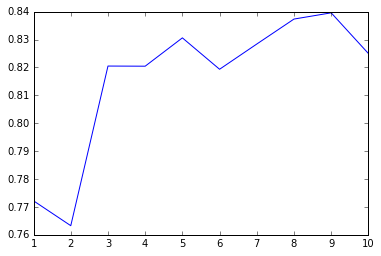

In [37]:
plt.plot(scores[:,:1],scores[:,1:2])

In [39]:
cross_val_score(rf, df[features], df['Survived'], cv=10).mean()

0.83731273408239704

Feature ranking:
1. feature 8 (0.213818)
2. feature 9 (0.190771)
3. feature 3 (0.150035)
4. feature 4 (0.117305)
5. feature 2 (0.082685)
6. feature 1 (0.077373)
7. feature 0 (0.061037)
8. feature 7 (0.048072)
9. feature 5 (0.038854)
10. feature 6 (0.020050)


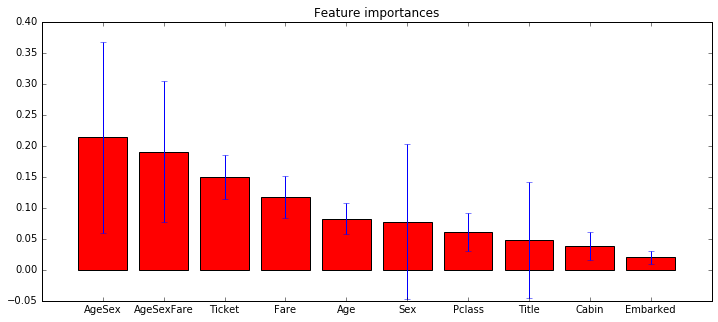

In [43]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), df_train.columns[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

In [38]:
features = [df_train.columns[feat_rank][x] for x in range(9)]
features

['AgeSex',
 'AgeSexFare',
 'Ticket',
 'Fare',
 'Age',
 'Sex',
 'Pclass',
 'Title',
 'Cabin']

In [51]:
# features = [df_train.columns[indices][x] for x in range(9)]
# features

In [45]:
X = df_train[features].values
X

array([[-2.75, -0.03891540829607214, 518, ..., 3, 28, -1],
       [4.75, 0.6608947430675433, 532, ..., 1, 80, 2],
       [3.25, 0.05027285190849946, 551, ..., 3, 50, -1],
       ..., 
       [3.5, 0.160199730954238, 553, ..., 3, 50, -1],
       [-3.25, -0.190307325836591, 8, ..., 1, 28, 2],
       [-4.0, -0.060507970265993034, 466, ..., 3, 28, -1]], dtype=object)

In [46]:
def create_submission(model, train, test, features, filename):

#     model.fit(train[features], train['Survived'])
    predictions = model.predict(test[features])

    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
    
    submission.to_csv(filename, index=False)

In [47]:
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = RandomForestClassifier()


# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 6),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              'n_estimators': [10, 40, 50, 60],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)



RandomizedSearchCV took 4.30 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.831 (std: 0.008)
Parameters: {'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 50, 'min_samples_split': 8, 'criterion': 'gini', 'max_features': 3, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.829 (std: 0.004)
Parameters: {'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 60, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 5, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.824 (std: 0.025)
Parameters: {'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 60, 'min_samples_split': 9, 'criterion': 'entropy', 'max_features': 4, 'max_depth': None}



In [50]:
# use a full grid over all parameters
param_grid = {'max_depth': [1, 2, 4, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_split': [1, 2, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4, 6],
              'bootstrap': [True, False],
              'n_estimators': [30, 40, 50, 60, 100],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 2313.00 seconds for 4800 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.846 (std: 0.022)
Parameters: {'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 100, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': None, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.846 (std: 0.022)
Parameters: {'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 40, 'min_samples_split': 10, 'criterion': 'gini', 'max_features': None, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.846 (std: 0.016)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 40, 'min_samples_split': 6, 'criterion': 'gini', 'max_features': None, 'max_depth': None}



In [49]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
create_submission(grid_search.best_estimator_,
                        df, df_test, features, "../submissions/rf_submission.csv")

## Random Forest Results

```
0.79426
['AgeSex', 'AgeSexFare', 'Fare', 'Sex', 'Pclass', 'Age']
create_submission(RandomForestClassifier(
                        bootstrap= True, 
                        min_samples_leaf= 3, 
                        n_estimators= 20, 
                        min_samples_split= 9, 
                        criterion= 'entropy', 
                        max_features= 4, 
                        max_depth= None)

0.78469
['AgeSex', 'AgeSexFare', 'Fare', 'Age', 'Pclass', 'Sex']
create_submission(RandomForestClassifier(50, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, predictors, "submission.csv")
0.76555
['AgeSex', 'AgeSexFare', 'Fare', 'Age']
create_submission(RandomForestClassifier(50, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, features, "submission.csv")
```

In [ ]:
trees_accuracy = []
for i in xrange(1,X.shape[1]):
    rf = RandomForestClassifier(50, max_features = i, min_samples_split=4, min_samples_leaf=2)
    rf.fit(X, y)
    trees_accuracy.append(rf.score(X,y))

In [ ]:
plt.plot(range(1, X.shape[1]), trees_accuracy, '-o')

## SVM

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(kernel='linear'))])
pipeline.fit(X, y)

In [ ]:
parameters = {'kernel':['linear','rbf'], 
              'C':np.linspace(.001,10,5),'degree':np.linspace(0,10,5)}

gsCV = GridSearchCV(estimator=pipeline.steps[1][1],
                    param_grid=parameters,scoring='accuracy', cv=5)

In [ ]:
X = pipeline.steps[0][1].fit_transform(X)

In [ ]:
gsCV.fit(X,y)

In [ ]:
gsCV.grid_scores_, gsCV.best_params_

mean: 0.78151, std: 0.03323, params: {'C': 25.00075, 'degree': 0.0}

In [ ]:
def svm_submission(model, train, test, features, filename):

    model.fit(train[features], train['Survived'])
    predictions = model.predict(test[features])

    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
    
    submission.to_csv(filename, index=False)

In [ ]:
svm_features = [df_train.columns[feat_rank][x] for x in range(8)]
svm_features

In [ ]:
create_submission(Pipeline([('scaler', StandardScaler()),
                    ('svc', SVC(kernel='rbf', C=2.5, degree=2.5))]), \
                  df, df_test, svm_features, "../submissions/svm_submission.csv")

## Gradient Boosting

In [ ]:
X = df_train
X.head()

In [ ]:
gdb = GradientBoostingClassifier(
                n_estimators=3000,
                learning_rate = 0.01, 
                max_depth = 4,
                max_features = 0.1,
                min_samples_leaf = 17)
gdb.fit(X,y)

In [ ]:
feat_rank = np.argsort(gdb.feature_importances_)[::-1]
feat_rank
df_train.columns[feat_rank]

In [ ]:
boost_features = [df_train.columns[feat_rank][x] for x in range(8)]
boost_features

In [ ]:
df_train[boost_features].head()

In [ ]:
X = df_train[boost_features]
X.head()

In [ ]:
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1]}
gdb_grid = GradientBoostingClassifier(n_estimators=6000)
gs_cv = GridSearchCV(gdb_grid, param_grid).fit(X,y)

gs_cv.best_params_

In [ ]:
gs_cv.grid_scores_

```
BEST PARAMS
{'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 0.1,
 'min_samples_leaf': 17}
 ```

In [ ]:
create_submission(GradientBoostingClassifier(
                n_estimators=3000,
                learning_rate = 0.01, 
                max_depth = 4,
                max_features = 0.1,
                min_samples_leaf = 9),
                df, df_test, boost_features, "../submissions/gdboost_submission.csv")

## Adaptive Boosting

In [ ]:
X = df_train
X.head()

In [ ]:
ada = AdaBoostClassifier(
                n_estimators=3000,
                learning_rate = 0.01)
ada.fit(X,y)

In [ ]:
feat_rank = np.argsort(ada.feature_importances_)[::-1]
ada_features = [df_train.columns[feat_rank][x] for x in range(6)]
ada_features

In [ ]:
X = df_train[ada_features]
X.head()

In [ ]:
param_grid = {'learning_rate': [1, 0.1, 0.05, 0.02, 0.01]}

ada_grid = AdaBoostClassifier(n_estimators=6000)
ada_cv = GridSearchCV(ada_grid, param_grid).fit(X,y)

ada_cv.best_params_

In [ ]:
create_submission(AdaBoostClassifier(
                n_estimators=3000,
                learning_rate = 0.01),
                df, df_test, ada_features, "../submissions/adaboost_submission.csv")